In [73]:
# Install necessary libraries
import json
import pandas as pd
# from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [74]:
# Mount:
# drive.mount('/content/drive', force_remount = True)

In [75]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

def merge_datasets_for_model(dfs):
    """
    Vertically concatenate multiple datasets.
    All rows are kept. Column names must be consistent.

    Parameters
    ----------
    dfs : list of pd.DataFrame
        List of datasets with identical column structure

    Returns
    -------
    pd.DataFrame
        Combined dataset
    """
    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    return merged_df



In [76]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [77]:
# Merge datasets for training
# data1 = readJsonData('Data/ambient_blue.json')
# df1 = preprocessData(data1)
# df1, _ = combineGroundTruth(df1)
# data2 = readJsonData('Data/Tai4.json')
# df2 = preprocessData(data2)
# df2, _ = combineGroundTruth(df2)
# data3 = readJsonData('Data/Baisu1.json')
# df3 = preprocessData(data3)
# df3, _ = combineGroundTruth(df3)
# df_train = merge_datasets_for_model([df3])

# Preprocessing testing data
jsonFilePath = 'Data/Baisu1.json'
data = readJsonData(jsonFilePath)
df = preprocessData(data)
df, _ = combineGroundTruth(df)
# df = df_train

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : baisu1
lightingCondition   : 0
useReflectiveSurface: False
dateTime            : 2025-11-19T15:01:46.558942

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).


## Method: Using Polynomial Correction  

The correction method uses three-channel polynomial regression:

$$
\hat{R} = f_R(R_m, G_m, B_m), \quad
\hat{G} = f_G(R_m, G_m, B_m), \quad
\hat{B} = f_B(R_m, G_m, B_m)
$$

where $R_m, G_m, B_m$ are the measured RGB values, and $f_R, f_G, f_B$ are polynomial functions.  

In matrix form:

$$
\hat{C} = X \cdot \Theta, \quad
X = [1, R_m^1, \dots, R_m^d, \; G_m^1, \dots, G_m^d, \; B_m^1, \dots, B_m^d]
$$

where $d$ is the polynomial degree, $\Theta$ is the coefficient vector, and $\hat{C} = [\hat{R}, \hat{G}, \hat{B}]$.

In [78]:
# ============================================================
# Design matrix: polynomial terms
# ============================================================
def build_design_matrix(measured_r, measured_g, measured_b, degree):
    """
    Build design matrix using all RGB channels.
    Each channel's polynomial terms are included.
    
    Returns:
        X: (N, 3*(degree+1))
           [1, r^1..r^degree, g^1..g^degree, b^1..b^degree]
    """
    N = len(measured_r)
    bias = np.ones((N, 1))
    # polynomial terms for each channel
    X_r = np.vstack([measured_r**k for k in range(1, degree+1)]).T
    X_g = np.vstack([measured_g**k for k in range(1, degree+1)]).T
    X_b = np.vstack([measured_b**k for k in range(1, degree+1)]).T
    # concatenate all
    X = np.hstack([bias, X_r, X_g, X_b])
    return X



# ============================================================
# Loss function (MSE + boundary penalty + L2 regularization)
# ============================================================
def regression_loss(theta, X, y, reg_lambda=1e-2):
    """
    theta: regression coefficients
    X: design matrix
    y: ground truth
    """
    y_pred = X @ theta
    mse = mean_squared_error(y, y_pred)
    # Penalize predictions outside valid intensity range
    lower_bound = 0.0
    upper_bound = 255.0

    penalty_low = np.mean(np.maximum(lower_bound - y_pred, 0.0)**2)
    penalty_high = np.mean(np.maximum(y_pred - upper_bound, 0.0)**2)

    boundary_penalty = penalty_low + penalty_high
    reg = reg_lambda * np.sum(theta**2)
    return mse + reg + boundary_penalty


# ============================================================
# Optimize one color channel
# ============================================================
def fit_single_channel(measured_r, measured_g, measured_b, gt, degree):
    """
    Fit polynomial model for one RGB channel using all channels.
    """
    X = build_design_matrix(measured_r, measured_g, measured_b, degree)
    # initial guess
    theta0 = np.zeros(X.shape[1])
    # roughly identity mapping for self channel
    theta0[1] = 1.0

    result = minimize(
        regression_loss,
        theta0,
        args=(X, gt),
        method="L-BFGS-B"
    )
    return {
        "theta": result.x,
        "success": result.success,
        "final_mse": mean_squared_error(gt, X @ result.x)
    }
    
def fit_rgb_polynomial(
    df,
    max_degree=5,
    meas_prefix="color_r4_",
    gt_prefix="gt__"
):
    """
    Fit polynomial regression for RGB channels using all channels as input.
    """
    measured_r = df[f"{meas_prefix}R"].values
    measured_g = df[f"{meas_prefix}G"].values
    measured_b = df[f"{meas_prefix}B"].values

    results = {}

    for ch, gt_col in zip(["R", "G", "B"], ["gt__R", "gt__G", "gt__B"]):
        gt = df[gt_col].values
        best_mse = np.inf
        best_result = None
        best_degree = None
        all_results = {}

        for degree in range(1, max_degree+1):
            res = fit_single_channel(measured_r, measured_g, measured_b, gt, degree)
            all_results[degree] = res

            print("degree",degree,"mse",res["final_mse"])
            if res["success"] and res["final_mse"] < best_mse:
                best_mse = res["final_mse"]
                best_result = res
                best_degree = degree

        results[ch] = {
            "best_degree": best_degree,
            "theta": best_result["theta"],
            "final_mse": best_mse,
            "success": best_result["success"],
            "all_results": all_results
        }
    return results


In [79]:
# ============================================================
# Polynomial correction (all channels)
# ============================================================
def correctByPolynomial(meas_r, meas_g, meas_b, coeffs):
    """
    Correct RGB values using a polynomial model.
    coeffs: array of shape (num_features,) learned from training
    """
    coeffs = np.asarray(coeffs, dtype=np.float64)

    # ensure all inputs are arrays
    meas_r = np.atleast_1d(np.asarray(meas_r, dtype=np.float64))
    meas_g = np.atleast_1d(np.asarray(meas_g, dtype=np.float64))
    meas_b = np.atleast_1d(np.asarray(meas_b, dtype=np.float64))

    # automatically infer degree from coeffs
    # number of features = 1 + 3*degree
    num_features = len(coeffs)
    degree = (num_features - 1) // 3
    if degree < 0 or num_features != 1 + 3 * degree:
        raise ValueError(f"Invalid number of coefficients: {len(coeffs)}, expected 1 + 3*degree")

    # build design matrix to match training
    N = len(meas_r)
    bias = np.ones((N, 1))
    X_r = np.vstack([meas_r**k for k in range(1, degree+1)]).T
    X_g = np.vstack([meas_g**k for k in range(1, degree+1)]).T
    X_b = np.vstack([meas_b**k for k in range(1, degree+1)]).T
    X = np.hstack([bias, X_r, X_g, X_b])  # shape (N, 1 + 3*degree)

    corr = X @ coeffs

    # return scalar if input was scalar
    return corr[0] if corr.size == 1 else corr


# ============================================================
# Dispatcher for row-wise correction
# ============================================================
from functools import partial

def apply_correction_dispatcher(row, color_prefix, radius,
                                correction_type,
                                coeffs_R=None, coeffs_G=None, coeffs_B=None):
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    if correction_type == 'white_scaling':
        # Use fixed white reference for scaling
        ref_r = 184.5
        ref_g = 171.8
        ref_b = 146.5
        corr_r = np.clip(meas_r * 255.0 / (ref_r if ref_r>0 else 1.0), 0, 255).astype(int)
        corr_g = np.clip(meas_g * 255.0 / (ref_g if ref_g>0 else 1.0), 0, 255).astype(int)
        corr_b = np.clip(meas_b * 255.0 / (ref_b if ref_b>0 else 1.0), 0, 255).astype(int)

    elif correction_type == 'polynomial':
        # Polynomial correction automatically matches coeffs
        corr_r = correctByPolynomial(meas_r, meas_g, meas_b, coeffs_R)
        corr_g = correctByPolynomial(meas_r, meas_g, meas_b, coeffs_G)
        corr_b = correctByPolynomial(meas_r, meas_g, meas_b, coeffs_B)

        # Clip and convert to integer
        corr_r = np.clip(corr_r, 0, 255).astype(int)
        corr_g = np.clip(corr_g, 0, 255).astype(int)
        corr_b = np.clip(corr_b, 0, 255).astype(int)
    else:
        raise ValueError(f"Unknown correction_type: {correction_type}")

    return pd.Series([corr_r, corr_g, corr_b])


# ============================================================
# Main function to apply corrections to DataFrame
# ============================================================
def correctRGB(df, correction_type, coeffs_R=None, coeffs_G=None, coeffs_B=None):
    """
    Apply correction to all r0, r2, r4 columns in DataFrame.
    Supports white_scaling or polynomial
    """

    partial_apply = partial(
        apply_correction_dispatcher,
        correction_type=correction_type,
        coeffs_R=coeffs_R,
        coeffs_G=coeffs_G,
        coeffs_B=coeffs_B
    )

    for radius in [0, 2, 4]:
        color_prefix = f'color_r{radius}'
        df[[f'correction_r{radius}_R', f'correction_r{radius}_G', f'correction_r{radius}_B']] = df.apply(
            lambda row: partial_apply(row, color_prefix, radius), axis=1
        ).clip(0, 255)

    # Compute MSE for polynomial (r4)
    if correction_type == 'polynomial':
        mse_r = mean_squared_error(df['gt__R'], df['correction_r4_R'])
        mse_g = mean_squared_error(df['gt__G'], df['correction_r4_G'])
        mse_b = mean_squared_error(df['gt__B'], df['correction_r4_B'])
        avg_mse = (mse_r + mse_g + mse_b) / 3.0
        print("\nPolynomial correction MSE (r4):")
        print(f"  R channel MSE: {mse_r:.2f}")
        print(f"  G channel MSE: {mse_g:.2f}")
        print(f"  B channel MSE: {mse_b:.2f}")
        print(f"  Average MSE : {avg_mse:.2f}")

    return df


In [80]:
def print_polynomial_coeffs_channel(coeffs, degree, channel_name):
    coeffs = np.asarray(coeffs, dtype=float)
    expected_len = 1 + 3 * degree

    print(f"\n=== {channel_name} channel ===")
    print(f"degree = {degree}")
    print(f"coeff length = {len(coeffs)} (expected {expected_len})")

    if len(coeffs) != expected_len:
        print("⚠️  WARNING: coefficient length does not match degree")
        return

    idx = 0

    # Bias term
    print(f"θ[{idx:2d}]  bias          = {coeffs[idx]: .6e}")
    idx += 1

    # R terms
    for k in range(1, degree + 1):
        print(f"θ[{idx:2d}]  r^{k:<2d}        = {coeffs[idx]: .6e}")
        idx += 1

    # G terms
    for k in range(1, degree + 1):
        print(f"θ[{idx:2d}]  g^{k:<2d}        = {coeffs[idx]: .6e}")
        idx += 1

    # B terms
    for k in range(1, degree + 1):
        print(f"θ[{idx:2d}]  b^{k:<2d}        = {coeffs[idx]: .6e}")
        idx += 1


In [81]:
best_result = fit_rgb_polynomial(df)

degree 1 mse 257.88470506192476
degree 2 mse 204.54101391761603
degree 3 mse 255.79337614729957
degree 4 mse 893.4247713303182
degree 5 mse 2374.85
degree 1 mse 160.83621666552452
degree 2 mse 136.12581018645318
degree 3 mse 184.13105071658367
degree 4 mse 1711.3875207747324
degree 5 mse 5275.4
degree 1 mse 357.3458294267657
degree 2 mse 250.85344448725402
degree 3 mse 280.8217565476377
degree 4 mse 1480.9618761178733
degree 5 mse 8194.680078462747


In [82]:


best_coeffs_R = best_result["R"]["theta"]
best_coeffs_G = best_result["G"]["theta"]
best_coeffs_B = best_result["B"]["theta"]
print_polynomial_coeffs_channel(
    best_coeffs_R,
    best_result["R"]["best_degree"],
    "R"
)

print_polynomial_coeffs_channel(
    best_coeffs_G,
    best_result["G"]["best_degree"],
    "G"
)

print_polynomial_coeffs_channel(
    best_coeffs_B,
    best_result["B"]["best_degree"],
    "B"
)


=== R channel ===
degree = 2
coeff length = 7 (expected 7)
θ[ 0]  bias          =  1.000671e-03
θ[ 1]  r^1         =  1.735599e+00
θ[ 2]  r^2         = -2.587405e-03
θ[ 3]  g^1         = -1.794485e-01
θ[ 4]  g^2         =  1.964995e-03
θ[ 5]  b^1         =  8.877777e-02
θ[ 6]  b^2         = -1.017069e-03

=== G channel ===
degree = 2
coeff length = 7 (expected 7)
θ[ 0]  bias          =  1.883457e-02
θ[ 1]  r^1         =  1.304842e-01
θ[ 2]  r^2         = -9.363288e-04
θ[ 3]  g^1         =  1.052942e+00
θ[ 4]  g^2         =  2.884316e-03
θ[ 5]  b^1         =  3.025096e-01
θ[ 6]  b^2         = -2.861585e-03

=== B channel ===
degree = 2
coeff length = 7 (expected 7)
θ[ 0]  bias          =  2.479737e-02
θ[ 1]  r^1         =  6.960532e-01
θ[ 2]  r^2         = -3.497568e-03
θ[ 3]  g^1         = -6.371684e-01
θ[ 4]  g^2         =  3.900052e-03
θ[ 5]  b^1         =  1.601864e+00
θ[ 6]  b^2         = -1.950700e-03


In [83]:

df = correctRGB(
    df,
    correction_type='polynomial',
    coeffs_R=best_coeffs_R,
    coeffs_G=best_coeffs_G,
    coeffs_B=best_coeffs_B
)
def rgb_to_hsv_wrapper(r, g, b):
    # Normalize RGB values to [0, 1]
    rgb_normalized = np.array([r, g, b]) / 255.0
    h, s, v = rgb_to_hsv(rgb_normalized)
    return pd.Series([h, s, v])

# Convert original RGB values to HSV and add to DataFrame
rgb_column_sets = [
    ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
    ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
    ('gt', '') # This entry needs to be fixed to match the new gt__R naming
]

for prefix, radius in rgb_column_sets:
    # Special handling for ground truth to match the double underscore naming
    if prefix == 'gt':
        r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
        h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
    else:
        r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
        h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

    df[[h_col, s_col, v_col]] = df.apply(
        lambda row: rgb_to_hsv_wrapper(row[r_col], row[g_col], row[b_col]),
        axis=1, result_type='expand'
    )
displayDataFrameInfo(df)


Polynomial correction MSE (r4):
  R channel MSE: 203.45
  G channel MSE: 136.36
  B channel MSE: 252.55
  Average MSE : 197.45

--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       baisu1              1              0                   0   
1       baisu1              1              1                   0   
2       baisu1              1              2                   0   
3       baisu1              1              3                   0   
4       baisu1              1              4                   0   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False -29.693001  1.293356         171         175   
1               False  -8.531617  0.876035         176         180   
2               False   5.271871  1.447423         179         182   
3               False  18.241475  1.187735         180         183   
4               False  30.369560  1.290507         181         184   

   

In [84]:
df_final_comparison = generateFinalDataFrame(df)
displayDataFrameInfo(df_final_comparison)


--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       baisu1              1              0                   0   
1       baisu1              1              1                   0   
2       baisu1              1              2                   0   
3       baisu1              1              3                   0   
4       baisu1              1              4                   0   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False -29.693001  1.293356         171         175   
1               False  -8.531617  0.876035         176         180   
2               False   5.271871  1.447423         179         182   
3               False  18.241475  1.187735         180         183   
4               False  30.369560  1.290507         181         184   

   white_r0_B  ...  avg_color_r2_B  avg_correction_r2_R  avg_correction_r2_G  \
0         178  ...            50.7                1

In [85]:
df_final_comparison[['gt__R', 'gt__G', 'gt__B']]

,gt__R,gt__G,gt__B
0,115,82,69
1,115,82,69
2,115,82,69
3,115,82,69
4,115,82,69
...,...,...,...
235,50,50,50
236,50,50,50
237,50,50,50
238,50,50,50


In [86]:
df_final_comparison[['color_r4_R', 'color_r4_G', 'color_r4_B']]

,color_r4_R,color_r4_G,color_r4_B
0,86,58,46
1,89,61,48
2,84,60,48
3,92,68,56
4,97,77,65
...,...,...,...
235,28,33,36
236,31,35,38
237,34,38,39
238,35,39,40


In [87]:
df_final_comparison[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']]

,correction_r4_R,correction_r4_G,correction_r4_B
0,128,82,79
1,132,87,82
2,125,85,82
3,136,97,92
4,143,109,104
...,...,...,...
235,44,48,55
236,49,50,58
237,53,54,60
238,55,56,62


In [88]:
a_sum_sq = ((df_final_comparison['gt__R'] - df_final_comparison['correction_r4_R']) ** 2).sum()
b_sum_sq = ((df_final_comparison['gt__G'] - df_final_comparison['correction_r4_G']) ** 2).sum()
c_sum_sq = ((df_final_comparison['gt__B'] - df_final_comparison['correction_r4_B']) ** 2).sum()

print(f"Sum of (a1 - a2)^2: {a_sum_sq}")
print(f"Sum of (b1 - b2)^2: {b_sum_sq}")
print(f"Sum of (c1 - c2)^2: {c_sum_sq}")

Sum of (a1 - a2)^2: 48827
Sum of (b1 - b2)^2: 32727
Sum of (c1 - c2)^2: 60612


In [89]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [90]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    if radius == 0: plt.savefig('Correction comparison with ground truth.png')
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

Plotting 24 unique samples for radius r0.


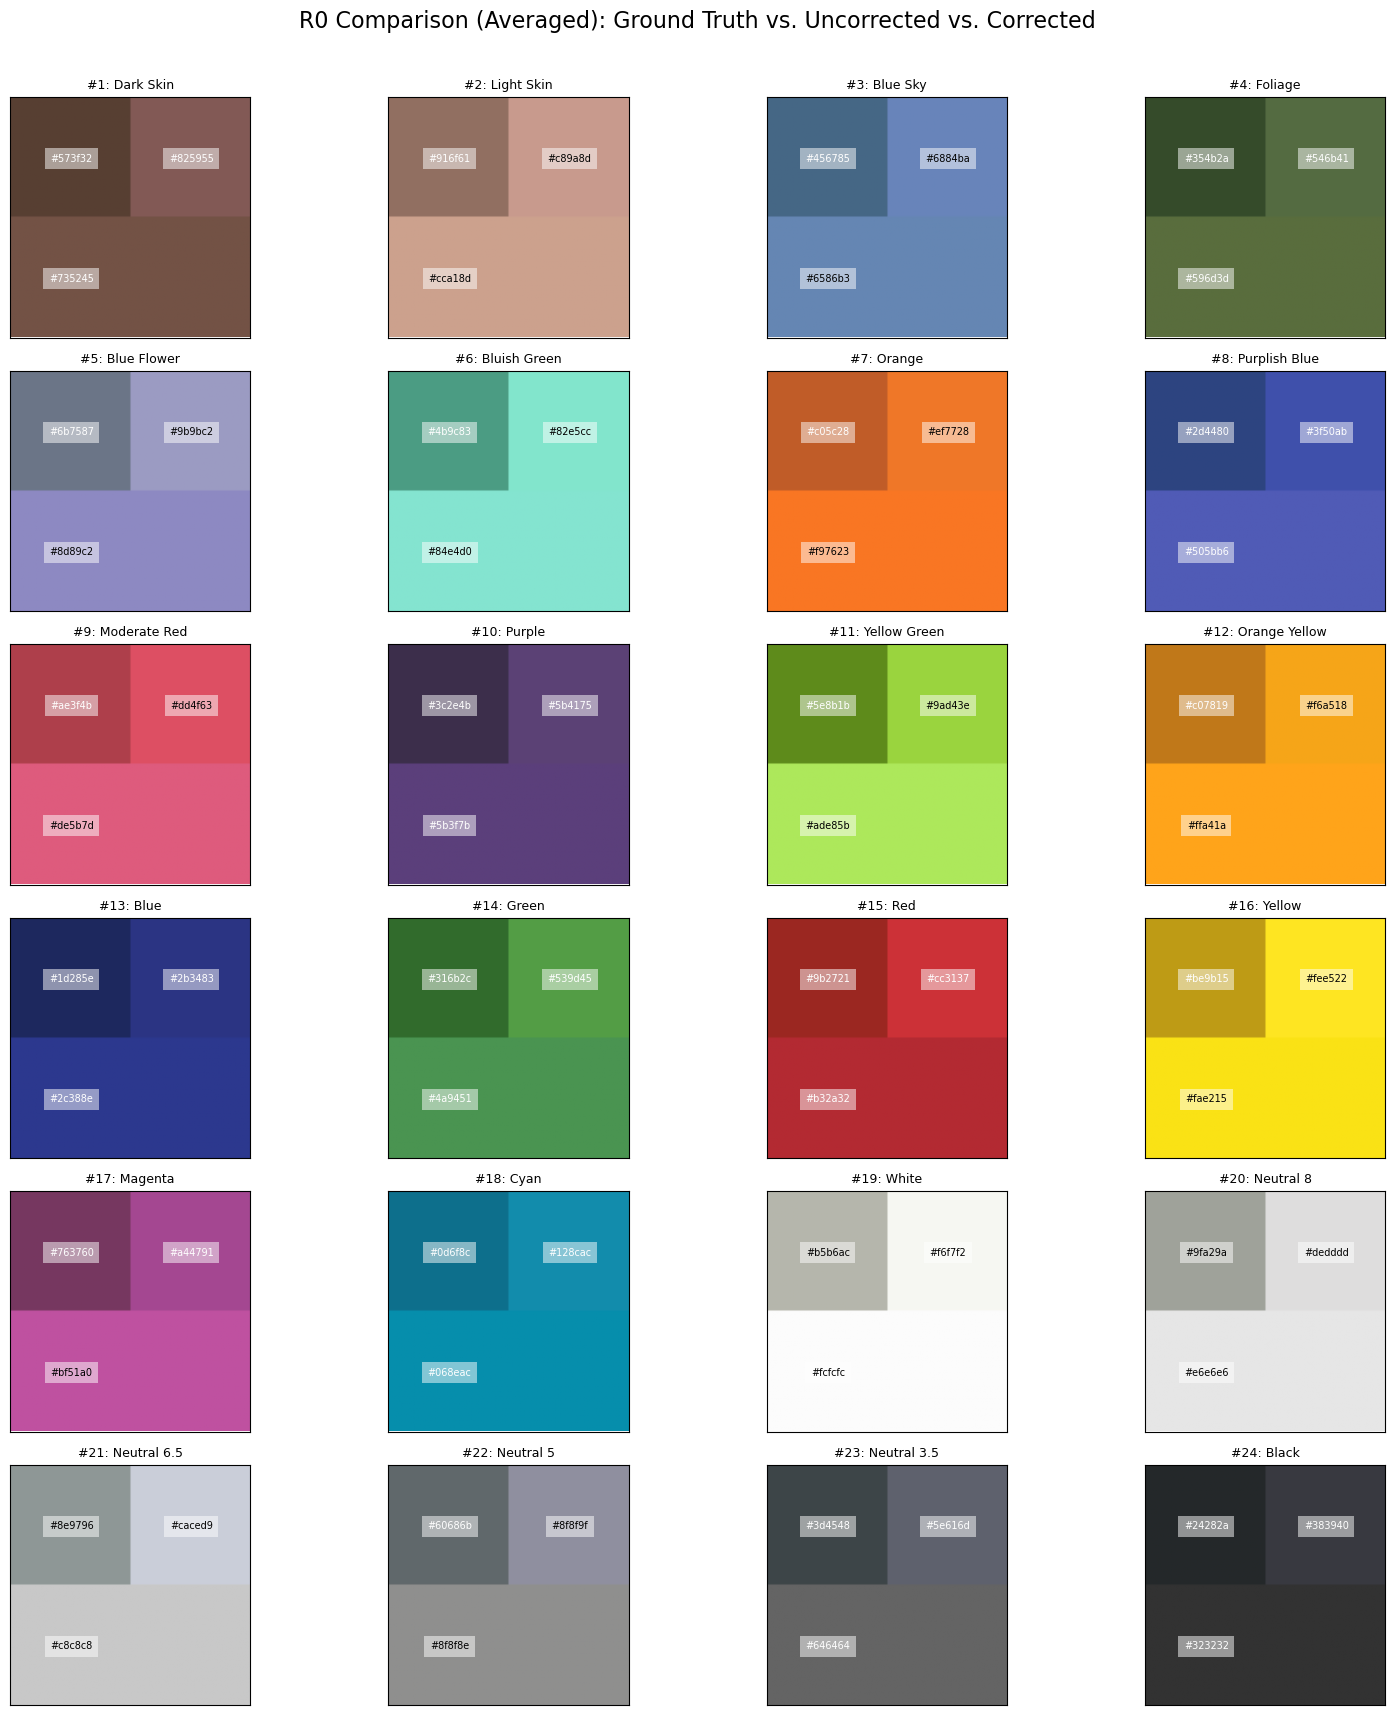

Plotting 24 unique samples for radius r2.


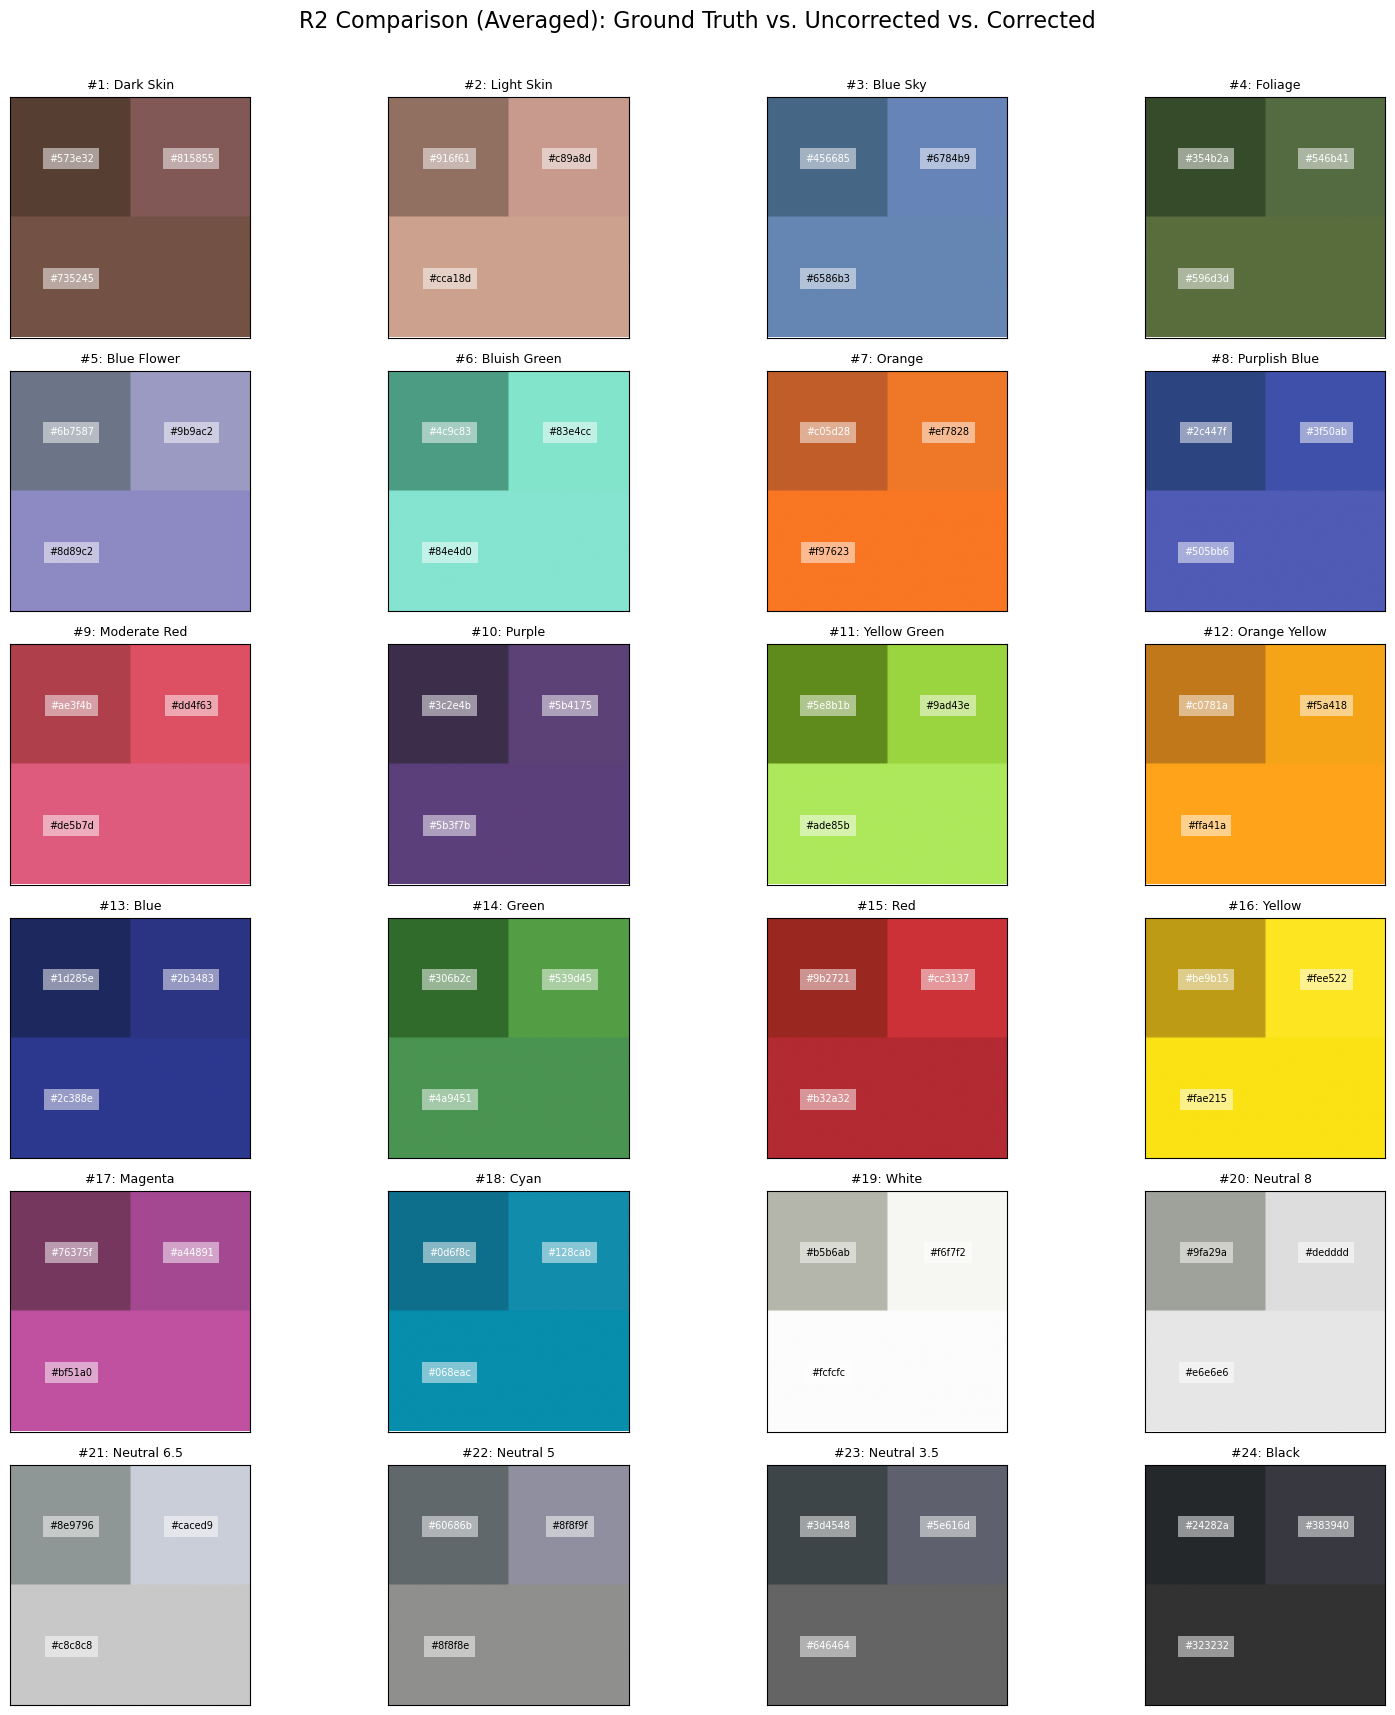

Plotting 24 unique samples for radius r4.


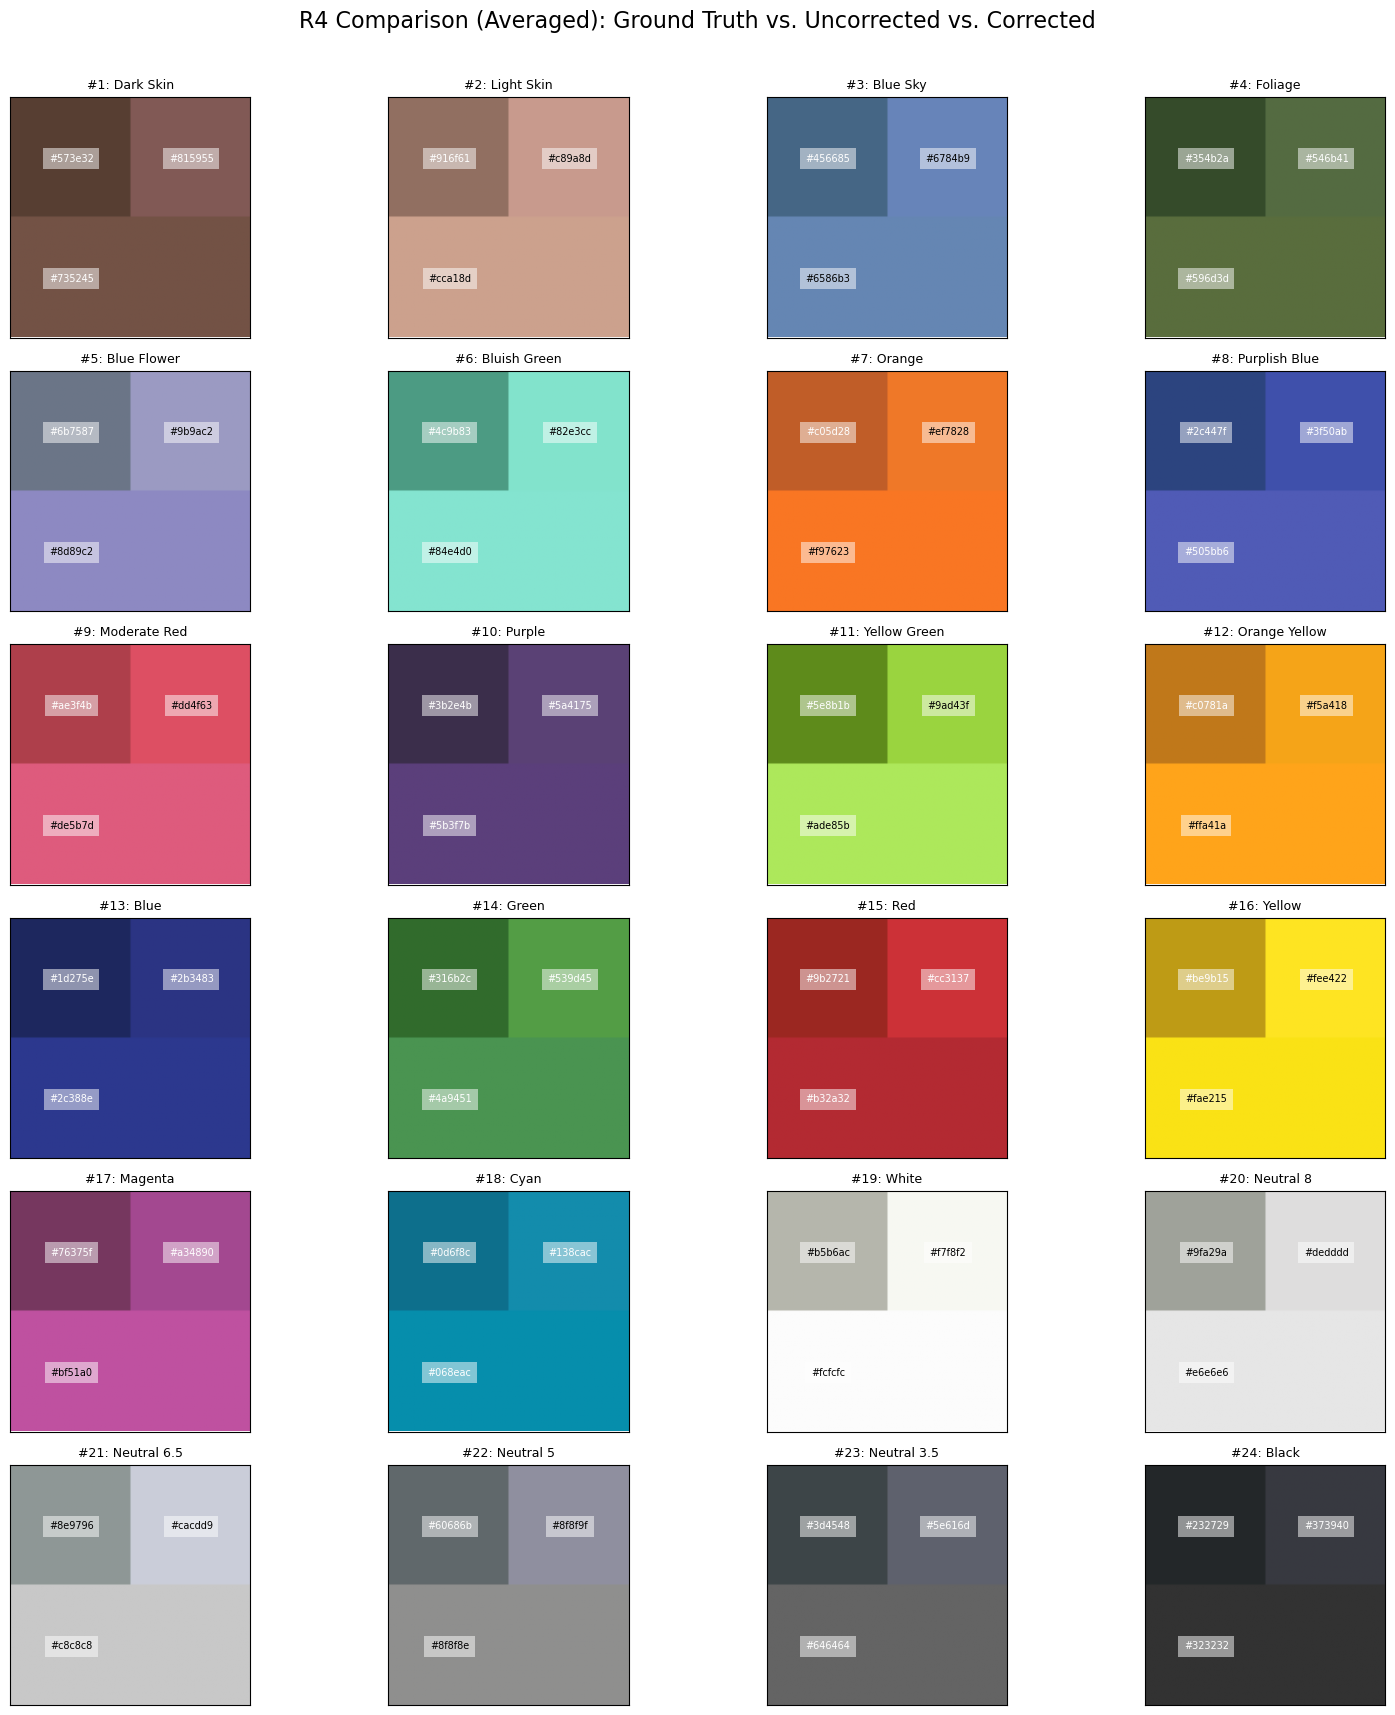

In [91]:
plotAllRadius(df_final_comparison)
# Not visually clear for human's eyes. But the MSE has decreased. A meticulous analysis would yield this is better.

In [92]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Calculate H_error considering the circular nature of Hue (normalized to 0-1)
  h_diff_uncorr = np.abs(df_final_comparison['uncorr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_uncorr'] = np.minimum(h_diff_uncorr, 1 - h_diff_uncorr)

  h_diff_corr = np.abs(df_final_comparison['corr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_corr'] = np.minimum(h_diff_corr, 1 - h_diff_corr)

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [93]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


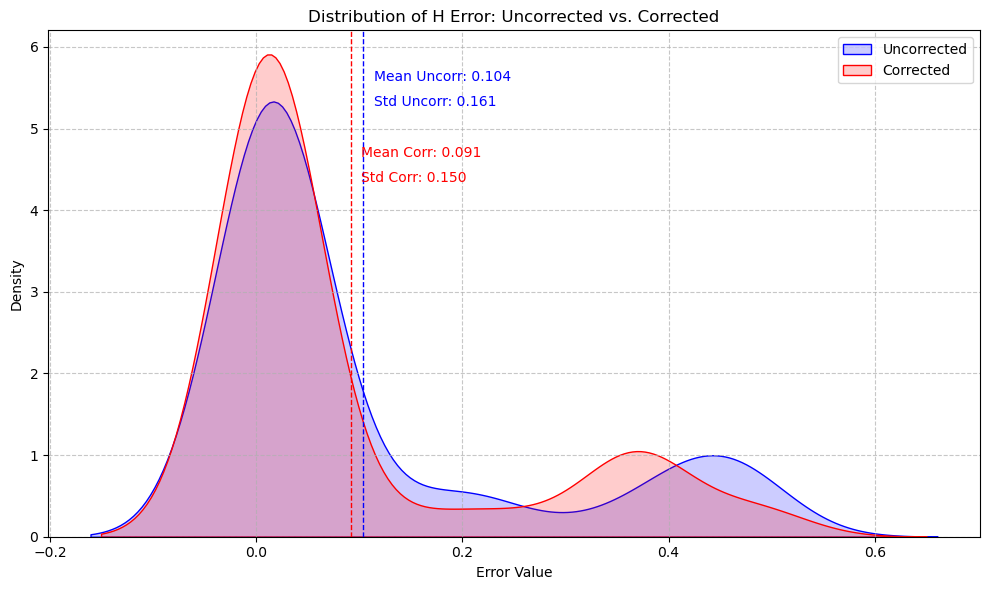

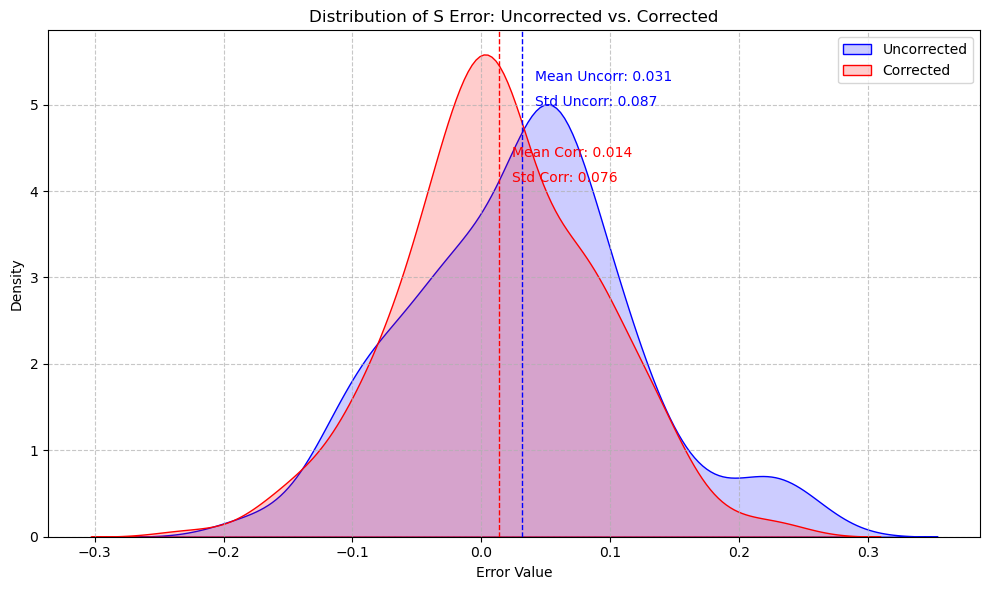

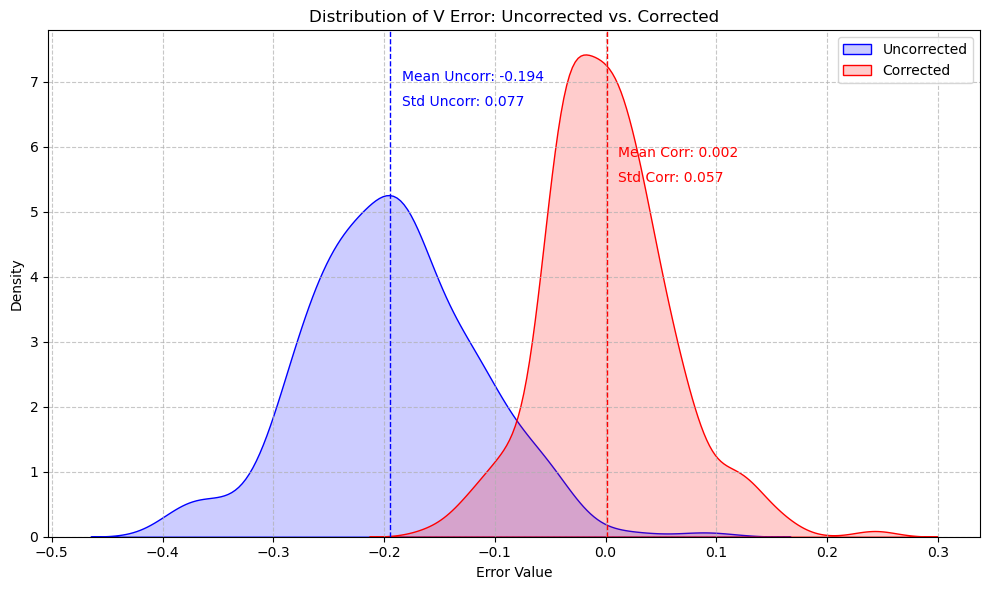

In [94]:
df = df_HSV(df)
plotHSV(df)

In [97]:

print("\nNew Polynomial Correction MSE:")
print(f"  R Channel MSE: {best_result['R']['final_mse']:.2f}")
print(f"  G Channel MSE: {best_result['G']['final_mse']:.2f}")
print(f"  B Channel MSE: {best_result['B']['final_mse']:.2f}")
print(f"  Average MSE: {(best_result['R']['final_mse']+best_result['G']['final_mse']+best_result['B']['final_mse'])/3:.2f}")


New Polynomial Correction MSE:
  R Channel MSE: 204.54
  G Channel MSE: 136.13
  B Channel MSE: 250.85
  Average MSE: 197.17
